This notebook documents the process of parsing the json drug label files from openFDA

In [70]:
import os
import json
import zipfile
import glob
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir="../../data/"
try:
    os.mkdir(data_dir)
except:
    print(data_dir+' exists')
downloads_dir=data_dir+"downloads/"
try:
    os.mkdir(downloads_dir)
except:
    print(downloads_dir+' exists')
    
out = data_dir+"parsed/"
try:
    os.mkdir(out)
except:
    print(out+' exists')
out_meta = out+"meta/"
try:
    os.mkdir(out_meta)
except:
    print(out_meta+' exists')

../../data/ exists
../../data/downloads/ exists
../../data/parsed/ exists
../../data/parsed/meta/ exists


In [3]:
drug_label_files = glob.glob(downloads_dir+"*.json.zip")

In [228]:
dfs = []
drug_label_file = drug_label_files[0]
for drug_label_file in drug_label_files:
    z = zipfile.ZipFile(drug_label_file, "r")
    for filename in z.namelist():   
        t0 = time.time()

        print(filename) 
        file_lst = filename.split('.')
        out_file = '_'.join(file_lst[:1])
        with z.open(filename) as f:  
            data = f.read()  
            d = json.loads(data.decode("utf-8"))

            meta = pd.json_normalize(d['meta'])
            (meta.
             to_csv(out_meta+out_file+'_meta.csv.gzip',
                        compression='gzip'))
            
            results = pd.json_normalize(d['results'])
            results.index = results['set_id'].values
            
            print('Parsing...')
            t0 = time.time()
            subs = []
            #fields = results.columns.sort_values().values
            fields = ['openfda.rxcui']
            n=results.shape[0]
            for field in fields:
                sub = \
                (pd.concat(
                    {k: pd.Series(v) for k, v in results.head(n)[field].items()}
                ).
                 reset_index().
                 drop('level_1',axis=1).
                 rename(columns={'level_0' : 'set_id',0 : field}).
                 set_index('set_id')
                )
                subs.append(sub)

            df = pd.concat(subs, axis=0)
            t1 = time.time()
            print(np.round(t1-t0,2),' seconds')
            
            dfs.append(df)

drug-label-0003-of-0009.json
Parsing...
2.25  seconds
drug-label-0008-of-0009.json
Parsing...
2.14  seconds
drug-label-0007-of-0009.json
Parsing...
2.76  seconds
drug-label-0002-of-0009.json
Parsing...
2.77  seconds
drug-label-0009-of-0009.json
Parsing...
1.46  seconds
drug-label-0006-of-0009.json
Parsing...
2.91  seconds
drug-label-0001-of-0009.json
Parsing...
2.28  seconds
drug-label-0005-of-0009.json
Parsing...
2.96  seconds
drug-label-0004-of-0009.json
Parsing...
2.27  seconds


In [235]:
pd.concat(dfs).dropna().shape[0]/pd.concat(dfs).shape[0]

0.38652945438218755

In [236]:
print(results.shape)
results.head()

(20000, 163)


,package_label_principal_display_panel,description,effective_time,spl_product_data_elements,version,warnings_and_cautions,id,set_id,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,pregnancy,...,components,teratogenic_effects_table,food_safety_warning,drug_and_or_laboratory_test_interactions_table,nonteratogenic_effects_table,accessories,troubleshooting,assembly_or_installation_instructions,environmental_warning,summary_of_safety_and_effectiveness
9367137e-200c-48c6-9634-135e1faeb101,[LABEL IMAGE LABEL IMAGE],[DESCRIPTION Phenytoin sodium is an antiepilep...,20100219,[PHENYTOIN ER PHENYTOIN SODIUM PHENYTOIN SODIU...,1,[CLINICAL PHARMACOLOGY Phenytoin is an antiepi...,c4783156-8357-488d-aaf4-83b1e5978529,9367137e-200c-48c6-9634-135e1faeb101,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51132e43-6fda-4cd4-a818-cfd399264e89,[PACKAGE LABEL.PRINCIPAL DISPLAY PANEL- 250 mg...,[DESCRIPTION Divalproex sodium is a stable co-...,20131229,[Divalproex Sodium Divalproex Sodium DIVALPROE...,1,NaN,c587a83e-6bd2-4645-8044-0884fbb2bc4f,51132e43-6fda-4cd4-a818-cfd399264e89,"[Carcinogenesis, Mutagenesis, Impairment of Fe...",[Pregnancy Pregnancy category D See WARNINGS ....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aa5fa6bc-87ba-4e8c-e053-2a95a90a7ded,[500 mL],NaN,20200713,[BioMiracle staysafe HAND SANITIZER ALCOHOL GL...,1,NaN,aa5fa38b-80a4-0d53-e053-2995a90a8de1,aa5fa6bc-87ba-4e8c-e053-2a95a90a7ded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a062586b-fc78-462c-848d-bc11d06b421d,[nm-good-mood-enhancer.jpg],NaN,20200714,"[Good Mood Enhancer Agrimonia eupatoria, flos,...",3,NaN,aa6b1be3-4086-4789-e053-2a95a90a0a7a,a062586b-fc78-462c-848d-bc11d06b421d,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aa6bf8e8-9287-0ea1-e053-2a95a90a1d08,[Package Label - Principal Display Panel 3785....,NaN,20200714,[Hand Sanitizer ALCOHOL TROLAMINE ALOE VERA LE...,1,NaN,aa6bf8e8-9279-0ea1-e053-2a95a90a1d08,aa6bf8e8-9287-0ea1-e053-2a95a90a1d08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
results.columns.sort_values().values

array(['abuse', 'accessories', 'active_ingredient',
       'active_ingredient_table', 'adverse_reactions',
       'adverse_reactions_table', 'animal_pharmacology_and_or_toxicology',
       'animal_pharmacology_and_or_toxicology_table', 'ask_doctor',
       'ask_doctor_or_pharmacist', 'ask_doctor_or_pharmacist_table',
       'ask_doctor_table', 'assembly_or_installation_instructions',
       'boxed_warning', 'boxed_warning_table',
       'carcinogenesis_and_mutagenesis_and_impairment_of_fertility',
       'carcinogenesis_and_mutagenesis_and_impairment_of_fertility_table',
       'cleaning', 'clinical_pharmacology', 'clinical_pharmacology_table',
       'clinical_studies', 'clinical_studies_table', 'components',
       'contraindications', 'contraindications_table',
       'controlled_substance', 'dependence', 'description',
       'description_table', 'disposal_and_waste_handling', 'do_not_use',
       'do_not_use_table', 'dosage_and_administration',
       'dosage_and_administration_ta

Text(0, 0.5, 'Number of labels')

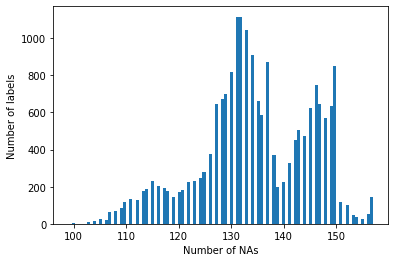

In [238]:
plt.hist(results.apply(lambda x : x.isna().sum(),1).sort_values().values,bins=100)
plt.xlabel("Number of NAs")
plt.ylabel("Number of labels")

Text(0, 0.5, 'Number of fields')

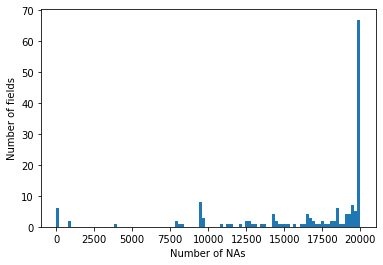

In [239]:
plt.hist(results.apply(lambda x : x.isna().sum(),0).sort_values().values,bins=100)
plt.xlabel("Number of NAs")
plt.ylabel("Number of fields")